# Faster R-CNN Model for Detection of wheat heads in the Images

For this problem, we will be finetuning a pre-trained Faster R-CNN model for wheat head detection in the images.  The reference can be found at the following link.
[Torchvision Referece](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html)

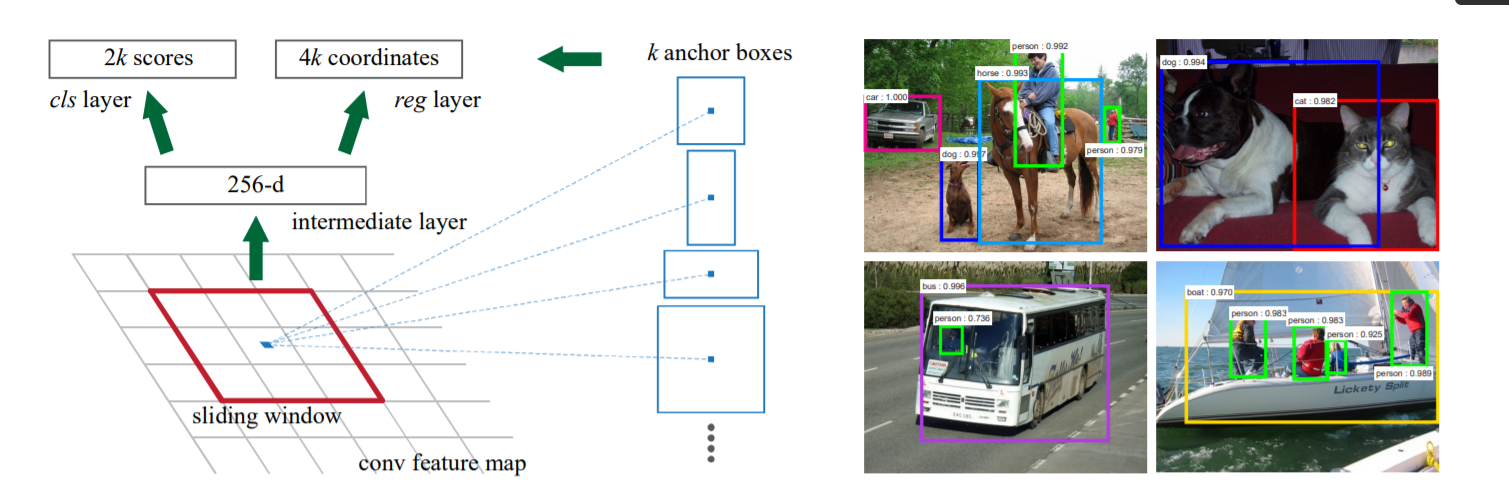

# Defining the Dataset 

We'll create a dataset to read the data and corresponding boxes and labels from the train folder .The dataset should inherit from the standard torch.utils.data.Dataset class, and implement \_\_len__ and \_\_getitem__.

The only specificity that we require is that the dataset \_\_getitem__ should return:

1. **image**: an image tensor of size (H, W)
2. **target**: a dict containing the following fields
    1. boxes (FloatTensor[N, 4]): the coordinates of the N bounding boxes in [x0, y0, x1, y1] format, ranging from 0 to W and 0 to H
    2. labels (Int64Tensor[N]): the label for each bounding box. 0 represents always the background class.

In [ ]:
import torch
import torchvision
import pandas as pd
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Lets define the custom dataset for our wheathead images:

In [ ]:
class wheatdataset(torch.utils.data.Dataset):
    def __init__(self,root,folder='train',transforms=None):
        self.transforms=[]
        if transforms!=None:
            self.transforms.append(transforms)
        self.root=root
        self.folder=folder
        box_data=pd.read_csv(os.path.join(root, "train.csv"))
        self.box_data=pd.concat([box_data,box_data.bbox.str.split('[').str.get(1).str.split(']').str.get(0).str.split(',',expand=True)],axis=1)
        self.imgs=list(os.listdir(os.path.join(root, self.folder)))
    def __len__(self):
        return len(self.imgs)
        
    def __getitem__(self,idx):
        img_path=os.path.join(os.path.join(self.root,self.folder),self.imgs[idx])
        img = Image.open(img_path).convert("RGB")
        df=self.box_data[self.box_data['image_id']==self.imgs[idx].split('.')[0]]
        if df.shape[0]!=0:
            df[2]=df[0].astype(float)+df[2].astype(float)
            df[3]=df[1].astype(float)+df[3].astype(float)
            boxes=df[[0,1,2,3]].astype(float).values
            labels=np.ones(len(boxes))
        else:
            boxes=np.asarray([[0,0,0,0]])
            labels=np.ones(len(boxes))
        for i in self.transforms:
            img=i(img)
            
        targets={}
        targets['boxes']=torch.from_numpy(boxes).double()
        targets['labels']=torch.from_numpy(labels).type(torch.int64)
        #targets['id']=self.imgs[idx].split('.')[0]
        return img.double(),targets

## And then create the dataset object from wheatdataset class.

In [ ]:
root='../input/global-wheat-detection'
dataset=wheatdataset(root,'train',transforms=torchvision.transforms.ToTensor())

In [ ]:
dataset[0]

As we can see, the dataset returns the images, boxes and corresponding labels in tensor format. 

**Note:** Here the labels only contains ones as one class is there i.e the wheat heads.

## Lets split train and test data and create Dataloaders to load data in batches:

In [ ]:
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset_train = torch.utils.data.Subset(dataset, indices[:-2500])
dataset_test = torch.utils.data.Subset(dataset, indices[-2500:])
data_loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=4, shuffle=True,collate_fn=lambda x:list(zip(*x)))
data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=4, shuffle=False,collate_fn=lambda x:list(zip(*x)))

## Lets see how our images looks like with the bounding boxes: 

In [ ]:
images,labels=next(iter(data_loader_train))
from matplotlib import patches
def view(images,labels,k,std=1,mean=0):
    figure = plt.figure(figsize=(30,30))
    images=list(images)
    labels=list(labels)
    for i in range(k):
        out=torchvision.utils.make_grid(images[i])
        inp=out.cpu().numpy().transpose((1,2,0))
        inp=np.array(std)*inp+np.array(mean)
        inp=np.clip(inp,0,1)  
        ax = figure.add_subplot(2,2, i + 1)
        ax.imshow(images[i].cpu().numpy().transpose((1,2,0)))
        l=labels[i]['boxes'].cpu().numpy()
        l[:,2]=l[:,2]-l[:,0]
        l[:,3]=l[:,3]-l[:,1]
        for j in range(len(l)):
            ax.add_patch(patches.Rectangle((l[j][0],l[j][1]),l[j][2],l[j][3],linewidth=2,edgecolor='w',facecolor='none')) 

view(images,labels,4)

# Time for some model building!!! 

### We'll take pretrained Faster R-CNN model from torchvision and change the roi head according to our needs

In [ ]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 2  # 1 class (person) + background
in_features = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model=model.to(device)


params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01)

## Lets train the model 

In [ ]:
model.train()
from tqdm.notebook import tqdm
for epoch in tqdm(range(1)):
    for images,targets in tqdm(data_loader_train):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        model=model.double()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()

        optimizer.zero_grad()
        optimizer.step()
        
    print("Loss = {:.4f} ".format(losses.item()))

torch.save(model.state_dict(), './model.pth')

### Since the model is heavy and it takes lots of time to train. I've trained the model on GPU and saved it as model.pth. Lets load the trained model.

In [ ]:
model.load_state_dict(torch.load('./model.pth'))

# Take a look at the test images after training:

In [ ]:
images,targets=next(iter(data_loader_test))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

model.eval()
output=model(images)

with torch.no_grad():
    view(images,output,2)

## Looks like more training is needed as very few wheat heads are detected. Will upload better trained model in coming days. 

# Thank you!! 